In [2]:
#Implementation of a normal RNN with L1 regularization for comparision with the spatially embedded rnn.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import bct
import pandas as pd

In [3]:
class MazeDataSet(Dataset):
    def __init__(self,data,labels):
        if data.shape[0] != labels.shape[0]:
            raise Exception("Number of data examples doesn't match number of labels",data.shape[0],labels.shape[0])
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,idx):
        data_point = self.data[idx]
        transform = transforms.ToTensor()
        data_point = torch.squeeze(transform(data_point))
        return data_point, self.labels[idx]

class mazeGeneratorI():
    '''
    Objects of the mazeGeneratorI class can create numpy and tf datasets of the first choice of the maze task.
    Task structure:
        Goal presentation, followed by delay period, followed by choice options.
    Response:
        One response required from agent at end of episode. Direction (Left, Up, Right, Down) of first step.
    Encoding:
        Both observations and labels are OneHot encoded.
    Usage:
        The two only function a user should need to access are "construct_numpy_data" and "construct_tf_data"
    Options:
        Both data construction methods have an option to shuffle the labels of data.
        The numpy data construction method allows to also return the maze identifiers.
    '''
    def __init__(self, goal_presentation_steps, delay_steps, choices_presentation_steps):
        self.version = 'v1.2.0'

        # Import variables defining episode
        self.goal_presentation_steps = goal_presentation_steps
        self.delay_steps = delay_steps
        self.choices_presentation_steps = choices_presentation_steps

        # Construct mazes dataframe
        ## Add encoded versions of the goal / choices presentations and the next step response
        self.mazesdf = self.import_maze_dic()
        self.mazesdf['Goal_Presentation'] = self.mazesdf['goal'].map({
            7:np.concatenate((np.array([1,0,0,0]),np.repeat(0,4))),
            9:np.concatenate((np.array([0,1,0,0]),np.repeat(0,4))),
            17:np.concatenate((np.array([0,0,1,0]),np.repeat(0,4))),
            19:np.concatenate((np.array([0,0,0,1]),np.repeat(0,4)))})
        self.mazesdf['Choices_Presentation']=self.mazesdf['ChoicesCategory'].map(lambda x: self.encode_choices(x=x))
        self.mazesdf['Step_Encoded']=self.mazesdf['NextFPmap'].map(lambda x: self.encode_next_step(x=x))

    def construct_numpy_data(self, number_of_problems, return_maze_identifiers = False, np_shuffle_data = False):
        # Create a new column which hold the vector for each problem
        self.mazesdf['Problem_Vec']=self.mazesdf.apply(lambda x: self.create_problem_observation(row= x,goal_presentation_steps= self.goal_presentation_steps,delay_steps= self.delay_steps,choices_presentation_steps= self.choices_presentation_steps), axis=1)
        # Set a random order of maze problems for the current session
        self.mazes_order = np.random.randint(0,8,number_of_problems)

        # Create vectors, holding observations and labels
        session_observation =np.array([])
        session_labels = np.array([])
        for i in self.mazes_order:
            session_observation = np.append(session_observation,self.mazesdf.iloc[i]['Problem_Vec'])
            session_labels = np.append(session_labels,self.mazesdf.iloc[i]['Step_Encoded'])

        # Reshape vectors to fit network observation and response space
        session_length = self.goal_presentation_steps + self.delay_steps + self.choices_presentation_steps
        session_observation = np.reshape(session_observation, (-1,session_length,8)).astype('float32')
        session_labels = np.reshape(session_labels, (-1,4)).astype('float32')

        # If np_shuffle_data == 'Labels, the order of labels is shuffled to randomise correct answers
        if np_shuffle_data == 'Labels':
          shuffle_generator = np.random.default_rng(38446)
          shuffle_generator.shuffle(session_labels,axis=0)

        # If return_maze_identifiers == 'IDs', return the array with maze IDs alongside the regular returns (observations, labels)
        if return_maze_identifiers == 'IDs':
          return session_observation, session_labels, self.mazes_order

        return session_observation, session_labels

    def construct_pt_data(self,number_of_problems,pt_shuffle_data=False):
        npds, np_labels = self.construct_numpy_data(number_of_problems=number_of_problems,np_shuffle_data=pt_shuffle_data)

        return MazeDataSet(npds,np_labels)

    def reset_construction_params(self, goal_presentation_steps, delay_steps, choices_presentation_steps):
        self.goal_presentation_steps = goal_presentation_steps
        self.delay_steps = delay_steps
        self.choices_presentation_steps = choices_presentation_steps

    def import_maze_dic(self, mazeDic=None):
        if mazeDic == None:
            # Set up dataframe with first choices of maze task
            ## The dictionary was generated using MazeMetadata.py (v1.0.0) and the following call:
            ### mazes.loc[(mazes['Nsteps']==2)&(mazes['ChoiceNo']=='ChoiceI')][['goal','ChoicesCategory','NextFPmap']].reset_index(drop=True).to_dict()
            self.mazesDic = {'goal': {0: 9, 1: 9, 2: 19, 3: 17, 4: 17, 5: 7, 6: 19, 7: 7},
            'ChoicesCategory': {0: 'ul',
            1: 'rd',
            2: 'ld',
            3: 'rd',
            4: 'ul',
            5: 'ur',
            6: 'lr',
            7: 'lr'},
            'NextFPmap': {0: 'u', 1: 'r', 2: 'd', 3: 'd', 4: 'l', 5: 'u', 6: 'r', 7: 'l'}}
        else:
            self.mazesDic = mazeDic

        # Create and return dataframe
        return pd.DataFrame(self.mazesDic)

    def encode_choices(self, x):
        # Helper function to create the observation vector for choice periods
        choices_sec = np.repeat(0,4)
        choicesEncoding = pd.Series(list(x))
        choicesEncoding = choicesEncoding.map({'l':1,'u':2,'r':3,'d':4})
        for encodedChoice in choicesEncoding:
            choices_sec[encodedChoice-1]=1
        return np.concatenate((np.repeat(0,4),choices_sec))

    def encode_next_step(self, x):
        # Helper function to change the response / action to a OneHot encoded vector
        step_sec = np.repeat(0,4)
        stepEncoding = pd.Series(list(x))
        stepEncoding = stepEncoding.map({'l':1,'u':2,'r':3,'d':4})
        for encodedStep in stepEncoding:
            step_sec[encodedStep-1]=1
        return step_sec

    def create_problem_observation(self, row, goal_presentation_steps, delay_steps, choices_presentation_steps):
        # Helper function to create one vector describing the entire outline of one maze problem (Goal presentation, Delay Period, and Choices Presentation)
        goal_vec = np.tile(row['Goal_Presentation'], goal_presentation_steps)
        delay_vec = np.tile(np.repeat(0,8), delay_steps)
        choices_vec = np.tile(row['Choices_Presentation'], choices_presentation_steps)
        problem_vec = np.concatenate((goal_vec,delay_vec,choices_vec))
        return problem_vec

    def __repr__(self):
        return '\n'.join([
            f'Maze DataSet Generator',
            f'Goal Presentation Steps: {self.goal_presentation_steps}',
            f'Delay Steps: {self.delay_steps}',
            f'Choices Presentation Steps: {self.choices_presentation_steps}'])

In [4]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
hidden_size = 100
num_layers = 1
l1_lambda = 0.001

#MAZE dataset
maze_data = mazeGeneratorI(goal_presentation_steps=20,delay_steps=10,choices_presentation_steps=20)
train_dataset_maze = maze_data.construct_pt_data(5120,True)
test_dataset_maze = maze_data.construct_pt_data(2000)
print("Generated Data...")
train_loader = DataLoader(dataset=train_dataset_maze, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset_maze, batch_size=batch_size, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Generated Data...
cuda


In [8]:
print(train_dataset_maze[0][1])

[0. 0. 0. 1.]


In [6]:
def compute_modularity(recurrent_weight):
    thresh = np.quantile(recurrent_weight,.9)
    mask = recurrent_weight > thresh
    binary_weights = np.zeros(recurrent_weight.shape)
    binary_weights[mask] = 1
    _, mod = bct.modularity_und(binary_weights,gamma=1)
    return mod


def compute_small_worldness(recurrent_weight):
    thresh = np.quantile(recurrent_weight,.9)
    mask = recurrent_weight > thresh
    binary_weights = np.zeros(recurrent_weight.shape)
    binary_weights[mask] = 1
    A = binary_weights
    clu = np.mean(bct.clustering_coef_bu(A))
    pth = bct.efficiency_bin(A)
    # Run nperm null models
    nperm = 1000
    cluperm = np.zeros((nperm,1))
    pthperm = np.zeros((nperm,1))
    for perm in range(nperm):
        Wperm = np.random.rand(100,100)
        # Make it into a matrix
        Wperm = np.matrix(Wperm)
        # Make symmetrical
        Wperm = Wperm+Wperm.T
        Wperm = np.divide(Wperm,2)
        # Binarise
        threshold, upper, lower = .7,1,0
        Aperm = np.where(Wperm>threshold,upper,lower)
        # Take null model
        cluperm[perm] = np.mean(bct.clustering_coef_bu(Aperm))
        pthperm[perm] = bct.efficiency_bin(Aperm)
    # Take the average of the nulls
    clunull = np.mean(cluperm)
    pthnull = np.mean(pthperm)
    # Compute the small worldness
    smw = np.divide(np.divide(clu,clunull),np.divide(pth,pthnull))
    return smw

In [18]:
# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Initialize model, loss function, and optimizer
model = RNN(input_size=8,hidden_size=hidden_size,num_layers=num_layers,num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def l1_reg(model,l1_lambda):
    return l1_lambda * sum([weight.abs().sum() for weight in model.parameters()])

def l2_reg(model,l1_lambda):
    #L2 regularization only on non recurrent weights -> SE1 takes care of regularization of recurrent parameters
    return l1_lambda * sum([weight.pow(2).sum() for name, weight in model.named_parameters()])

losses = []
modularity = []
small_worldness = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.squeeze(1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss += l2_reg(model,l1_lambda)
        loss.backward()
        optimizer.step()
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            losses.append(loss.item())
            numpy_weight = model.state_dict()["rnn.weight_hh_l0"].detach().cpu().numpy()
            modularity.append(compute_modularity(numpy_weight))
            small_worldness.append(compute_small_worldness(numpy_weight))

# Evaluation
model.eval() 
correct = 0
total = 0
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted[:,np.newaxis] == labels).sum().item()

print(f'Accuracy of the model on the 10000 test data: {100 * correct / total}%')


Epoch [1/20], Step [50/80], Loss: 0.5769


C:\Users\ankit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Epoch [2/20], Step [50/80], Loss: 0.3263
Epoch [3/20], Step [50/80], Loss: 1.2002
Epoch [4/20], Step [50/80], Loss: 0.6981
Epoch [5/20], Step [50/80], Loss: 0.5350
Epoch [6/20], Step [50/80], Loss: 0.5186
Epoch [7/20], Step [50/80], Loss: 0.5458
Epoch [8/20], Step [50/80], Loss: 0.2186
Epoch [9/20], Step [50/80], Loss: 0.1700
Epoch [10/20], Step [50/80], Loss: 0.1488
Epoch [11/20], Step [50/80], Loss: 0.2703
Epoch [12/20], Step [50/80], Loss: 0.2718
Epoch [13/20], Step [50/80], Loss: 0.2568
Epoch [14/20], Step [50/80], Loss: 0.1767
Epoch [15/20], Step [50/80], Loss: 0.1891
Epoch [16/20], Step [50/80], Loss: 0.0577
Epoch [17/20], Step [50/80], Loss: 0.0527
Epoch [18/20], Step [50/80], Loss: 0.0513
Epoch [19/20], Step [50/80], Loss: 0.0499
Epoch [20/20], Step [50/80], Loss: 0.0494
Accuracy of the model on the 10000 test images: 98.5%


### Graph Losses

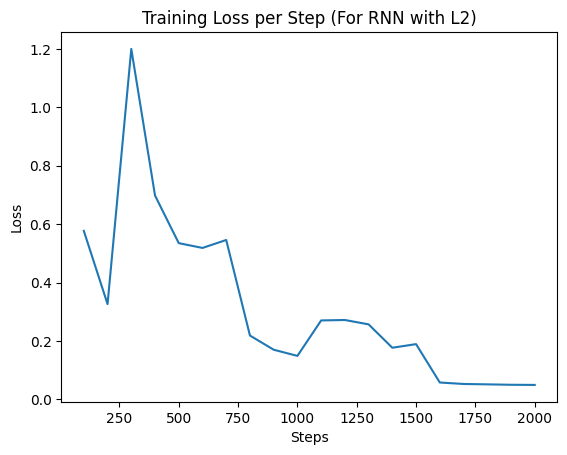

In [19]:
plt.plot(np.array(range(1,len(losses)+1)) * 100,losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss per Step (For RNN with L2)")
plt.show()

### Modularity

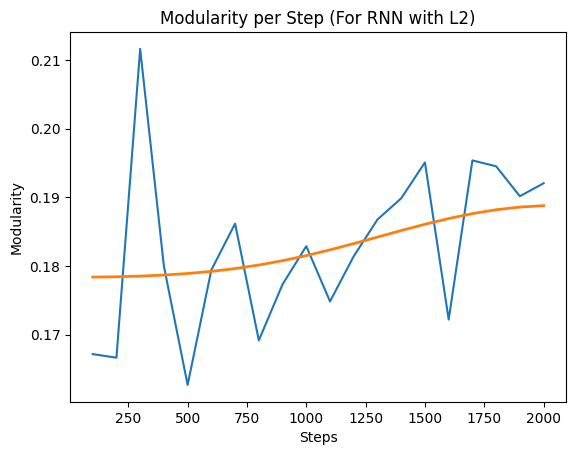

In [20]:
#Figure out a way to graph the small-worldness etc.
#Compute modularity of both forward layer or just rnn layer?

#Need to split it, create a function that calculates modularity, then graph the modularity as we go on.
from scipy.ndimage import gaussian_filter1d
smoothed_mod = gaussian_filter1d(modularity,5)
plt.plot(np.array(range(1,len(losses)+1)) * 100,modularity)
plt.plot(np.array(range(1,len(losses)+1)) * 100,smoothed_mod,linewidth=2)

plt.xlabel("Steps")
plt.ylabel("Modularity")
plt.title("Modularity per Step (For RNN with L2)")
plt.show()

### Small Worldness

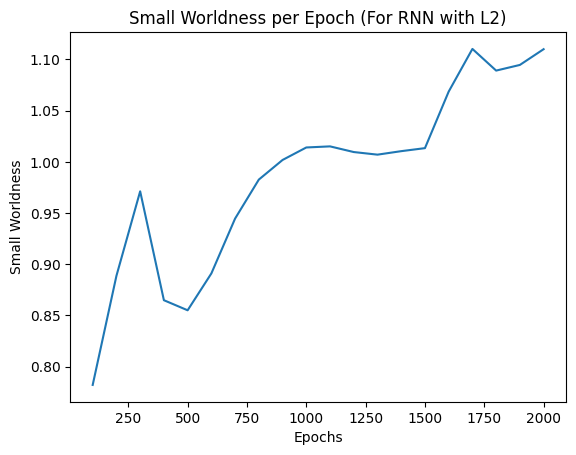

In [21]:
#Figure out a way to graph the small-worldness etc.
#Compute modularity of both forward layer or just rnn layer?

#Need to split it, create a function that calculates modularity, then graph the modularity as we go on.
#Only once per epoch because its expensive
plt.plot(np.array(range(1,len(losses)+1)) * 100,small_worldness)
plt.xlabel("Epochs")
plt.ylabel("Small Worldness")
plt.title("Small Worldness per Epoch (For RNN with L2)")
plt.show()

In [22]:
print(model.state_dict()["rnn.weight_hh_l0"].clone())

tensor([[-0.0518,  0.0014, -0.0809,  ..., -0.0436, -0.0533,  0.0865],
        [ 0.0419,  0.1141, -0.0284,  ...,  0.0042,  0.0583,  0.0938],
        [-0.0766, -0.0059, -0.0899,  ...,  0.0729,  0.0517,  0.0405],
        ...,
        [ 0.0083, -0.0374, -0.0723,  ...,  0.0611,  0.0094, -0.1075],
        [-0.0027,  0.0246,  0.0221,  ...,  0.0094,  0.0071, -0.0024],
        [ 0.0417,  0.1039,  0.0031,  ..., -0.1064, -0.0053,  0.0022]],
       device='cuda:0')


In [23]:
#___RESULTS____
#97.51% - L2 regularization, hidden size = 180
#96.55% - L2 regularization, hidden size = 70
# 95.2%- L1 regularization l1, hidden size = 100
i = 0
for n, p in model.named_parameters():
    i += 1
    if p.requires_grad:
         print(p.data.shape)
         print(n)
         print(i)

#I want to look at rnn.weight_hh_l0, and rnn.weight_hh_l1. These are where the recurrent connections are present.


torch.Size([100, 8])
rnn.weight_ih_l0
1
torch.Size([100, 100])
rnn.weight_hh_l0
2
torch.Size([100])
rnn.bias_ih_l0
3
torch.Size([100])
rnn.bias_hh_l0
4
torch.Size([4, 100])
fc.weight
5
torch.Size([4])
fc.bias
6
